# Introduction to Data Science
## From correlation to supervised segmentation and tree-structured models

Spring 2018 - Prof. Foster Provost

Teacher Assistant: Nicholas Garcia


***

### Packages and functions

We are going to need a lot of Python **packages**, so let's start by importing all of them.

In [7]:
# Import the libraries we will be using

import os
import numpy as np
import pandas as pd
import math
import matplotlib.patches as patches
import matplotlib.pylab as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from IPython.display import Image

%matplotlib inline

We are also going to do a lot of repetitive stuff, so let's predefine some useful **FUNCTIONS**:

Remember the basic aspects of a function:

* Input -> Parameters
* Actions
* Output -> Return

(We might have no _return_ which is basically just an action usually known as procedure. Also, We will see in other classes that these functions can also be taken from a **SCRIPT !!!**)


In [127]:

# A function that gives a visual representation of the decision tree

def Decision_Tree_Image(decision_tree, feature_names, class_names, name="tree"):
    
    # Export our decision tree to graphviz format
    dot_file = tree.export_graphviz(decision_tree, out_file='images/' + name + '.dot', 
                                    feature_names=feature_names, class_names=class_names)
        
    # Call graphviz to make an image file from our decision tree
    os.system("dot -Tpng images/" + name + ".dot -o images/" + name + ".png")
    # to get this part to actually work, you may need to open a terminal window in Jupyter and run the following command "sudo apt install graphviz"
    
    # Return the .png image so we can see it
    return Image(filename='images/' + name + '.png')




# A function to plot the data

def Plot_Data(data, v1, v2, tv):
    # Make the plot square
    plt.rcParams['figure.figsize'] = [12.0, 8.0]
    
    # Color
    color = ["red" if x == 0 else "blue" for x in data[tv]]
    
    # Plot and label
    plt.scatter(data[v1], data[v2], c=color, s=50)
    plt.xlabel(v1)
    plt.ylabel(v2)
    plt.xlim([min(data[v1]) , max(data[v1]) ])
    plt.ylim([min(data[v2]) , max(data[v2]) ])
    

    
# A function that creates the surface of a decision tree

def Decision_Surface(data, target, model):
    # Get bounds
    x_min, x_max = data[data.columns[0]].min(), data[data.columns[0]].max()
    y_min, y_max = data[data.columns[1]].min(), data[data.columns[1]].max()
    
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max,0.01), np.arange(y_min, y_max,0.01))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    
    plt.figure(figsize=[12,7])
    Z = model.predict(meshed_data).reshape(xx.shape)
            
    plt.title("Decision surface")    
    plt.ylabel("humor")
    plt.xlabel("number_pets")
    cs = plt.contourf(xx, yy, Z, levels=[-1,0,1],cmap=plt.cm.coolwarm,origin='lower')

    color = ["blue" if t == 0 else "red" for t in target]
    plt.scatter(data[data.columns[0]], data[data.columns[1]], color=color )
    

### Data creation

We also need some data, so let's create a dataset consisting of **500** people (rows) with **3** different variables (columns): `["age", "humor", "number_pets"]` 

The **target** of our prediction will be whether or not a person feels successful. We will call it "success" ( **binary** -> 0/1 values ).

In [121]:
# Set the randomness
np.random.seed(36)

# Number of users
n_users = 500

# Relationships
variable_names = ["age", "humor", "number_pets"]
variables_keep = ["number_pets", "humor"]
target_name = "success"

# Generate data with the "datasets" function from SKLEARN (package)
# This function returns two variables: predictors and target

predictors, target = datasets.make_classification(n_features=3, n_redundant=0, 
                                                  n_informative=2, n_clusters_per_class=2,
                                                  n_samples=n_users)

# We will write this data in a dataframe (pandas package)

data = pd.DataFrame(predictors, columns=variable_names)

# We want to take each column of the dataframe to change the values 

data['age'] = data['age'] * 10 + 50
data['humor'] = data['humor'] * 10 + 50
data['number_pets'] = (data['number_pets'] + 6)/2
data[target_name] = target

# Our variables (features) will be stored in one variable called X
X = data[[variables_keep[0], variables_keep[1]]]

# Our target will be stored in one variable called Y
Y = data[target_name]


We can (and should) take a look at the first few rows/records of our data to see what we are dealing with.

In [76]:
# Last 5 values

X.tail()

,number_pets,humor
495,1.852890,42.733283
496,3.695582,59.853848
497,3.461373,40.452224
498,3.812595,44.556818
499,3.125810,75.720112


In [77]:
# Target variable: success

Y.head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    1
9    1
Name: success, dtype: int64

### One feature and splits
Let's take a look at one of our features -- **`"number_pets"`**. Is this feature useful? 

- Let's look at a scatter plot the possible values of `"number_pets"` and color code our target variable, `"success"`. Red dots mean unsuccessful people and blue dots mean successful people. 
- The horizontal value is the number of pets they have. The vertical position here doesn't mean anything (everyone has a one). 

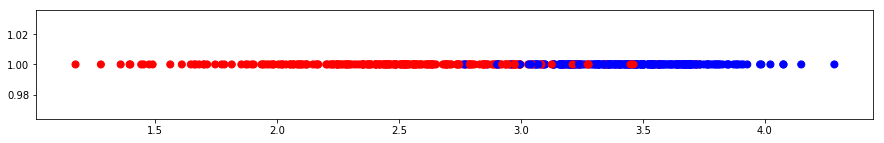

In [78]:

plt.rcParams['figure.figsize'] = [15.0, 2.0]

color = ["red" if x == 0 else "blue" for x in data["success"]]

plt.scatter(X['number_pets'], [1] * n_users, c=color, s=50)


***

Can we say that a number of pets below 3 is a good point to differentiate succesful?  

Let's quantify it.


**Entropy** ($H$) and **information gain** ($IG$) can help determine which features are the most informative. These metrics are used with categorical (i.e. discrete-valued) variables. Continuous (e.g. numeric) variables can be converted into categories by choosing thresholds along which to split the feature.

<table style="border: 0px">
<tr style="border: 0px">
<td style="border: 0px"><img src="images/dsfb_0304.png" height=80% width=80%>
Figure 3-4. Splitting the "write-off" sample into two segments, based on splitting the Balance attribute (account balance) at 50K.</td>
<td style="border: 0px; width: 30px"></td>
<td style="border: 0px"><img src="images/dsfb_0305.png" height=75% width=75%>
Figure 3-5. A classification tree split on the three-values Residence attribute.</td>
</tr>
</table>

##### Functions to get the entropy and IG
Entropy and information gain are both relatively easy to calculate using the method below.

In [79]:

def entropy(target):
    # Get the number of instances
    n = len(target)
    # Count how frequently each unique target value occurs using the numpy function 
    counts = np.bincount(target).astype(float)
    # Initialize entropy
    entropy = 0
    
    # Otherwise, for each possible value, update entropy; use zero for 0 log 0
    for count in counts:
        if count == 0:
            entropy += 0
        else:
            entropy += math.log(count/n, 2) * count/n
    # Return entropy
    return -1 * entropy

def information_gain(feature, threshold, target):
    # Dealing with numpy arrays makes this slightly easier
    target = np.array(target)
    feature = np.array(feature)
    # Cut the feature vector on the threshold
    feature = (feature < threshold)
    # Initialize information gain with the parent entropy
    ig = entropy(target)
    # For both sides of the threshold, update information gain
    for level, count in zip([0, 1], np.bincount(feature).astype(float)):
        ig -= count/len(feature) * entropy(target[feature == level])
    # Return information gain
    return ig

Remember we thought that 3 pets looked like a good cutoff point? let's see how much information gain ($IG$) we get.

In [80]:

threshold = 3
print ("IG = %.4f with thresholding of %.2f." % (information_gain(X['number_pets'], threshold, np.array(Y)), threshold))


IG = 0.5973 with thresholding of 3.00.


To be more precise, we can iterate through all values and find the best split.

In [81]:

def best_threshold():
    maximum_ig = 0
    maximum_threshold = 0

    for threshold in X['number_pets']:
        ig = information_gain(X['number_pets'], threshold, np.array(Y))
        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = threshold

    return "The maximum IG = %.3f and it occured by splitting on %.4f." % (maximum_ig, maximum_threshold)

print ( best_threshold() )


The maximum IG = 0.603 and it occured by splitting on 3.0326.


### All features and splits with the sklearn package !

Let's see how we can do this with just sklearn! Now, we will be using all the variables in X, not only number of pets!

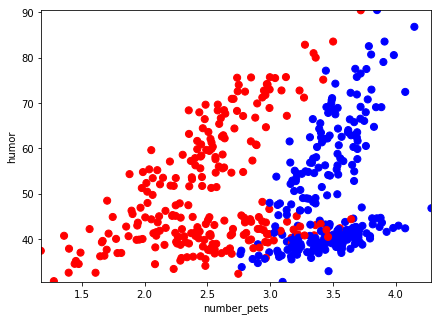

In [82]:
plt.figure(figsize=[7,5])
Plot_Data(data, "number_pets",  "humor","success")

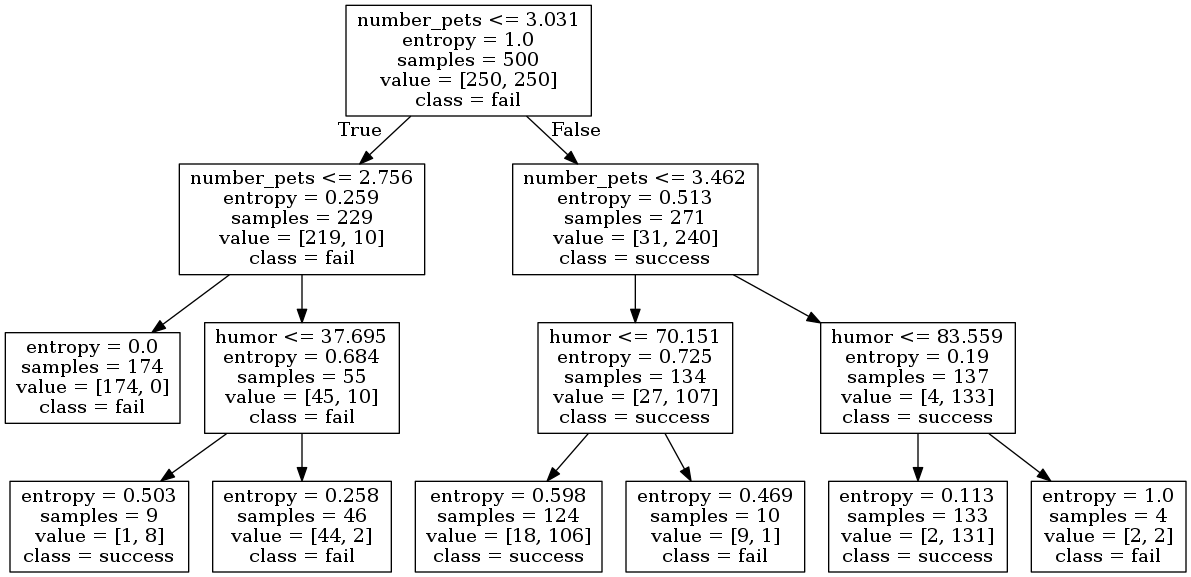

In [128]:
# Let's define the model (tree)
my_tree = DecisionTreeClassifier(max_depth=3,criterion="entropy")   # Look at those 2 arguments !!! 

# Let's tell the model what is the data
my_tree.fit(X, Y)

#Let's print an image with the results
Decision_Tree_Image(my_tree, X.columns, class_names =['fail','success'])

Let's look at the `"humor"`and `"number_pets"`, including the **DECISION SURFACE!!**

More details for this graph: [sklearn decision surface](http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html)

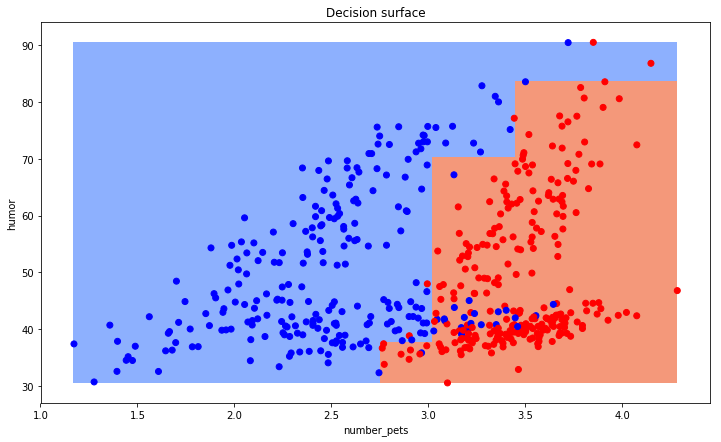

In [33]:
Decision_Surface(X,Y,decision_tree)

In [129]:
print ( "Accuracy = %.3f" % (metrics.accuracy_score(decision_tree.predict(X), Y)) )

Accuracy = 0.948
